## MATRIZ DE RIESGO - CLUSTERING

In [1]:
import pandas as pd
import numpy.random as rnd
import numpy as np

# Cluster 
from scipy.spatial import distance_matrix
from scipy.cluster.vq import vq, kmeans
from scipy.spatial.distance import cdist
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as sklearnPCA
from sklearn import decomposition
from sklearn import preprocessing

# Graficas
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import cycle
import seaborn as sns

%matplotlib inline

pd.options.display.float_format = '{:,.3f}'.format
plt.rcParams['figure.figsize'] = (7, 5)

C:\Users\eangenello\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


In [2]:
data = pd.read_excel(r'C:\Users\eangenello\Desktop\PYTHON\input\MATRIZ\Indicadores Matriz de Riesgo.xlsx')

In [3]:
data.head()

,Segmento,Cod Cia,DenominacionCorta,periodo,ind_01,num_Ind_01,den_Ind_01,ind_02,num_Ind_02,den_Ind_02,...,den_Ind_40,ind_41,num_Ind_41,den_Ind_41,ind_42,num_Ind_42,den_Ind_42,ind_43,num_Ind_43,den_Ind_43
0,Personas_s/RM,822,INSTITUTO DE JUJUY,2012-2,-0,0.000,3.000,-0,0.000,3.000,...,0.000,"387,69097668131125380196012166",5735888,14795,"15085,8958333333","724,123.000",48.000,"15085,8958333333","724,123.000",48.000
1,Patrimoniales_Mixtas,823,IÚNIGO,2012-2,-0,0.000,"3,665,705.000",-0,0.000,"3,665,705.000",...,0.000,"74,16577861587392932931184199",14434218,194621,"0,672766652474309","3,288,219.000","4,887,607.000","0,672766652474309","3,288,219.000","4,887,607.000"
2,Automotores,2,SMG,2012-3,"0,146802925879989","41,770,748.000","284,536,209.000","0,139001427483297","8,058,769.000","57,976,160.000",...,nan,"0,5918434595360580881707175794",33452221,56522076,"0,421782094960691","54,141,183.000","128,362,924.000","0,47388384323878","46,894,994.000","98,958,837.000"
3,Personas_s/RM,6,SURCO,2012-3,"5,28517543245643E-02","1,023,863.000","19,372,356.000",NaN,nan,"5,284,657.000",...,nan,"318,61462722769224444490123127",31000566,97298,"0,372488110469793","9,516,993.000","25,549,790.000","0,376081738996534","9,510,393.000","25,288,101.000"
4,Patrimoniales_Mixtas,7,CAMINOS PROTEGIDOS,2012-3,-0,0.000,"6,515,693.000",-0,0.000,"2,733,053.000",...,0.000,"78,684587253461694745725627481",27690916,351923,"0,161439910008841","627,453.000","3,886,604.000","0,166781140703654","627,453.000","3,762,134.000"


In [4]:
#Filtro período
data = data[(data.periodo=='2019-2')]

# Reemplazo NA
data = data.fillna(0)

# Remplazo los "den_cero"
data = data.replace(to_replace='den_cero', value=0)

#Quito outlier
#data=data[(data['Cod Cia']!=389)]

# Quito cia: LIDERAR MOTOS QUE NO EMITE HACE 3 MESES
data = data[(data['Cod Cia']!=858)]

In [5]:
#Filtro las columnas

colum = ['Cod Cia','Segmento','ind_01','ind_02','ind_03','ind_04','ind_05','ind_06','ind_08','ind_09','ind_10','ind_11','ind_12',
'ind_13','ind_14','ind_15','ind_16','ind_17','ind_18','ind_19','ind_20','ind_21','ind_22','ind_23','ind_24','ind_25',
'ind_26','ind_27','ind_28','ind_29','ind_30','ind_31','ind_32','ind_33','ind_34','ind_35','ind_36','ind_37','ind_38',
'ind_39','ind_40','ind_41','ind_42','ind_43']

data = data[colum]

### Dataset Automotor

In [6]:
data_autom= data.copy()

# Filtro ramo automotor
data_autom= data_autom[(data_autom.Segmento=='Automotores')]

# Reseteo el indice
data_autom= data_autom.reset_index()

# Me quedo a parte con la columna de compañias
cias_autom = data_autom['Cod Cia']

# Filtro todo lo que no sea indicadores
data_autom= data_autom.iloc[:, 3:]

# Quito indicadores que no se calculan para AUTOMOTORES (26, 33, 40)
data_autom=data_autom.drop({'ind_26','ind_33', 'ind_40'}, 1)

In [7]:
# Reemplazo punto por coma y lo convierto en flotante

for i in data_autom.columns:
    data_autom[i] = data_autom[i].map(lambda x: x if isinstance(x,int) else float(x.replace(",",".")))

In [8]:
data_autom.head()

,ind_01,ind_02,ind_03,ind_04,ind_05,ind_06,ind_08,ind_09,ind_10,ind_11,...,ind_32,ind_34,ind_35,ind_36,ind_37,ind_38,ind_39,ind_41,ind_42,ind_43
0,0.119,0.068,0.007,0.242,-0.034,0.846,0.000,0.232,0.000,0.050,...,1.679,0.096,0.269,0.291,1.342,0.837,0.725,2.950,0.417,0.504
1,0.100,0.006,0.011,0.345,-0.015,0.858,0.000,0.526,0.002,0.266,...,1.398,0.199,0.288,0.125,1.156,0.567,0.558,12.987,0.541,0.589
2,0.115,0.023,0.011,0.270,-0.055,0.874,0.356,0.093,0.000,0.000,...,1.637,0.297,0.209,0.129,1.195,0.612,0.585,5.675,0.537,0.583
3,0.234,0.233,0.010,0.225,-0.022,0.824,0.324,0.428,0.071,0.061,...,1.639,0.153,0.190,0.333,1.231,0.803,0.846,10.476,0.367,0.428
4,0.117,0.015,0.049,0.229,-0.030,0.781,0.441,0.627,0.002,0.161,...,1.250,0.260,0.175,0.086,1.027,0.549,0.586,8.565,0.438,0.478


In [9]:
# Cantidad de Filas + Cantidad de Columnas

data_autom.shape

(45, 39)

### Normalización

In [56]:
# Metodo máximo minimo
# por columna
data_autom_norm = pd.DataFrame()

for i in data_autom.columns:
    data_autom_norm[i] = (data_autom[i] - data_autom[i].min()) /(data_autom[i].max() - data_autom[i].min())
    
#data_autom_norm = (data_autom - data_autom.min()) /(data_autom.max() - data_autom.min())

In [11]:
#%% Se normalizan los datos con MinMax()
#min_max_scaler = preprocessing.MinMaxScaler() 
#data_autom_norm = pd.DataFrame(data=min_max_scaler.fit_transform(data_autom), columns= data_autom.columns) # Hay que convertir a DF el resultado.

In [12]:
#scalar = StandardScaler()

#data_autom_norm_standar = pd.DataFrame(data=scalar.fit_transform(data_autom),  columns= data_autom.columns)

In [13]:
# Media y Varianza

#normalize = Normalizer()

#data_autom_norm= pd.DataFrame(data=normalize.fit_transform(data_autom),  columns= data_autom.columns)

data_autom_norm.head()

,ind_01,ind_02,ind_03,ind_04,ind_05,ind_06,ind_08,ind_09,ind_10,ind_11,...,ind_32,ind_34,ind_35,ind_36,ind_37,ind_38,ind_39,ind_41,ind_42,ind_43
0,0.241,0.092,0.027,0.410,0.882,0.830,0.000,0.272,0.000,0.150,...,0.166,0.000,0.109,0.672,0.210,0.155,0.126,0.004,0.051,0.186
1,0.203,0.008,0.044,0.608,0.954,0.847,0.000,0.618,0.003,0.805,...,0.129,0.230,0.123,0.288,0.181,0.074,0.075,0.019,0.104,0.217
2,0.233,0.031,0.045,0.464,0.802,0.869,0.485,0.110,0.000,0.000,...,0.161,0.448,0.066,0.297,0.187,0.088,0.083,0.008,0.103,0.215
3,0.473,0.315,0.041,0.379,0.926,0.799,0.442,0.503,0.119,0.184,...,0.161,0.127,0.053,0.768,0.193,0.144,0.164,0.015,0.030,0.158
4,0.237,0.020,0.200,0.387,0.896,0.741,0.602,0.736,0.004,0.488,...,0.110,0.366,0.041,0.197,0.161,0.069,0.084,0.012,0.060,0.176


In [14]:
#data_autom_norm.to_excel(r'C:\Users\eangenello\Desktop\AutomotorNorm.xlsx', sheet_name='Autom', index=False)

### Correlación

In [15]:
mat_correl = np.corrcoef(pd.DataFrame.transpose(data_autom))

col=['ind_01', 'ind_02', 'ind_03', 'ind_04', 'ind_05', 'ind_06', 'ind_08',
       'ind_09', 'ind_10', 'ind_11', 'ind_12', 'ind_13', 'ind_14', 'ind_15',
       'ind_16', 'ind_17', 'ind_18', 'ind_19', 'ind_20', 'ind_21', 'ind_22',
       'ind_23', 'ind_24', 'ind_25', 'ind_27', 'ind_28', 'ind_29', 'ind_30',
       'ind_31', 'ind_32', 'ind_34', 'ind_35', 'ind_36', 'ind_37', 'ind_38',
       'ind_39', 'ind_41', 'ind_42', 'ind_43']

mat_correl = pd.DataFrame(mat_correl, columns=col , index=col)
mat_correl.head()

,ind_01,ind_02,ind_03,ind_04,ind_05,ind_06,ind_08,ind_09,ind_10,ind_11,...,ind_32,ind_34,ind_35,ind_36,ind_37,ind_38,ind_39,ind_41,ind_42,ind_43
ind_01,1.000,0.758,0.276,0.147,0.044,0.123,0.223,0.256,0.030,0.202,...,-0.099,-0.233,-0.162,0.852,0.039,-0.164,-0.119,-0.236,-0.193,0.094
ind_02,0.758,1.000,0.134,0.079,0.072,0.167,0.233,0.339,-0.014,0.057,...,-0.069,-0.233,-0.114,0.725,0.028,-0.088,-0.075,-0.168,-0.152,0.055
ind_03,0.276,0.134,1.000,0.018,-0.075,-0.114,0.180,0.254,-0.050,-0.026,...,0.191,0.155,-0.101,0.138,0.051,-0.164,-0.128,0.108,-0.023,0.151
ind_04,0.147,0.079,0.018,1.000,-0.083,-0.037,-0.135,-0.025,-0.141,-0.021,...,-0.079,-0.066,0.185,0.226,0.026,-0.059,-0.050,-0.179,0.121,0.068
ind_05,0.044,0.072,-0.075,-0.083,1.000,0.503,-0.011,0.023,0.129,0.104,...,-0.486,-0.228,-0.353,0.085,-0.287,-0.466,-0.467,0.115,-0.407,-0.279


In [16]:
#mat_correl.to_excel(r'output\Correlación.xlsx')

In [17]:
# Quito los indicadores correlacionados por más del 85%

# 'ind_27','ind_29','ind_25','ind_39','ind_42','ind_43','ind_39'

#autom_model = data_autom_norm.drop({'ind_27','ind_29','ind_25','ind_39','ind_42','ind_43','ind_39'},1)

In [18]:
# Me quedo con los indicadores raíz

autom_model = data_autom_norm[['ind_04','ind_20','ind_22','ind_19']]


In [55]:
autom_model

,ind_04,ind_20,ind_22,ind_19
0,0.410,0.651,0.301,0.930
1,0.608,0.882,0.045,0.964
2,0.464,0.758,0.001,0.956
3,0.379,0.885,0.436,0.948
4,0.387,1.000,0.131,0.987
5,0.347,0.824,0.252,0.959
6,0.476,0.702,0.000,0.980
7,0.574,0.736,0.125,0.945
8,0.447,0.858,0.051,0.967
9,0.175,0.896,1.000,0.992


### Modelo Clustering

#### Método del codo (Elbow Method)
Este método utiliza los valores de la inercia obtenidos tras aplicar el K-means a diferente número de Clusters (desde 1 a N Clusters), siendo la inercia la suma de las distancias al cuadrado de cada objeto del Cluster a su centroide:

<img src=https://jarroba.com/wp-content/uploads/2016/05/kmeans_inercia_jarroba.png>

Una vez obtenidos los valores de la inercia tras aplicar el K-means de 1 a N Clusters, representamos en una gráfica lineal la inercia respecto del número de Clusters. En esta gráfica se debería de apreciar un cambio brusco en la evolución de la inercia, teniendo la línea representada una forma similar a la de un brazo y su codo. El punto en el que se observa ese cambio brusco en la inercia nos dirá el número óptimo de Clusters a seleccionar para ese data set; o dicho de otra manera: el punto que representaría al codo del brazo será el número óptimo de Clusters para ese data set.

In [20]:
X = pd.DataFrame(autom_model).values

max_k = 10 
K = range(1,max_k)
ssw = []
centroid = [sum(X)/len(X) for i in K]
sst = sum(np.min(cdist(X, centroid, 'euclidean'), axis = 1))


for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    
    centers = pd.DataFrame(kmeanModel.cluster_centers_)
    labels = kmeanModel.labels_
    
    ssw_k = sum(np.min(cdist(X, kmeanModel.cluster_centers_, "euclidean"), axis = 1))
    ssw.append(ssw_k)

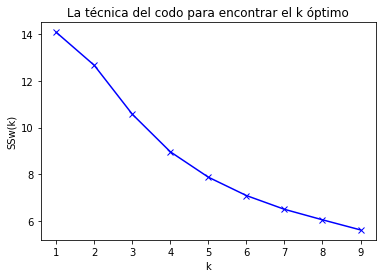

In [21]:
#Representación del codo
plt.plot(K, ssw, "bx-")
plt.xlabel("k")
plt.ylabel("SSw(k)")
plt.title("La técnica del codo para encontrar el k óptimo")
plt.show()

#### K Means

In [22]:
# Defino la cantidad de Clusters
n_clusters=5

# Defino el modelo
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

# Aplico el modelo al dataset
clusters = kmeans.fit_predict(autom_model)

# Visualizo la candidad de clusters y centroides
kmeans.cluster_centers_.shape

(5, 4)

In [23]:
# Visualizo el array de clusters
clusters

array([2, 3, 2, 0, 1, 1, 2, 3, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 3, 1, 0,
       2, 1, 2, 0, 2, 0, 2, 1, 2, 2, 3, 4, 3, 1, 1, 2, 1, 1, 0, 1, 3, 1,
       2])

In [24]:
# Visualizo las etiquetas del modelo 

kmeans.labels_

array([2, 3, 2, 0, 1, 1, 2, 3, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 3, 1, 0,
       2, 1, 2, 0, 2, 0, 2, 1, 2, 2, 3, 4, 3, 1, 1, 2, 1, 1, 0, 1, 3, 1,
       2])

In [25]:
# Convierto las etiquetas en una serie 

md_k = pd.Series(kmeans.labels_)

In [26]:
# Genero el dataset con los indicadores, los clusters y la compañía para poder identificarlas 

Autom_CM = autom_model.copy()
Autom_CM["clust_k"] = md_k
Autom_CM['cod_cia'] = cias_autom

Autom_CM.head()

,ind_04,ind_20,ind_22,ind_19,clust_k,cod_cia
0,0.410,0.651,0.301,0.930,2,2
1,0.608,0.882,0.045,0.964,3,25
2,0.464,0.758,0.001,0.956,2,32
3,0.379,0.885,0.436,0.948,0,36
4,0.387,1.000,0.131,0.987,1,39


(array([10.,  0., 16.,  0.,  0., 12.,  0.,  6.,  0.,  1.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

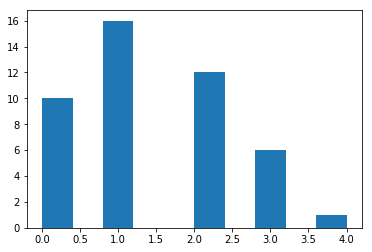

In [27]:
# Veo la frecuencia de los clusters

plt.hist(md_k)

In [34]:
# Agrego la denominación de la compañía

den_corta = pd.read_excel(r'C:\Users\eangenello\Desktop\PYTHON\input\ART\Dataset_Compañías.xlsx', usecols='A,B')

Autom_CM = Autom_CM.merge(den_corta, how='left', on=['cod_cia'])

Autom_CM.head()

,ind_04,ind_20,ind_22,ind_19,clust_k,cod_cia,denominacion_corta_x,denominacion_corta_y
0,0.410,0.651,0.301,0.930,2,2,SMG,SMG
1,0.608,0.882,0.045,0.964,3,25,SURA,SURA
2,0.464,0.758,0.001,0.956,2,32,BOSTON,BOSTON
3,0.379,0.885,0.436,0.948,0,36,ALLIANZ,ALLIANZ
4,0.387,1.000,0.131,0.987,1,39,QBE BUENOS AIRES,QBE BUENOS AIRES


In [29]:
# Exporto Dataset

Autom_CM.to_excel(r'C:\Users\eangenello\Desktop\PYTHON\output\Cluster Automotor.xlsx', sheet_name='Autom', index=False)

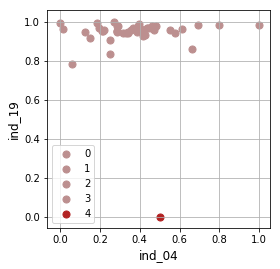

In [77]:
a='ind_04'
b='ind_19'

fig = plt.figure(figsize = (4,4))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel(a, fontsize = 12)
ax.set_ylabel(b, fontsize = 12)
ax.set_title('', fontsize = 15)


targets = sorted(Autom_CM['clust_k'].unique())
colors = ['rosybrown', 'rosybrown', 'rosybrown', 'rosybrown', 'firebrick']

for target, color in zip(targets,colors):
    indicesToKeep = Autom_CM['clust_k'] == target
    ax.scatter(Autom_CM.loc[indicesToKeep, a]
               , Autom_CM.loc[indicesToKeep, b]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

### PCA para graficar

#### Variabilidad a representar

Text(0,0.5,'varianza explicada acumulada')

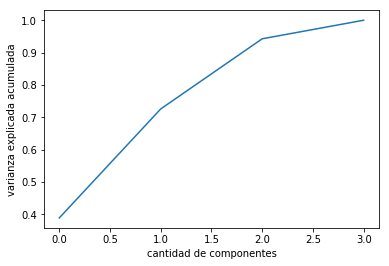

In [36]:
pca = sklearnPCA().fit(autom_model)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('cantidad de componentes')
plt.ylabel('varianza explicada acumulada')

In [37]:
pca_eval = sklearnPCA(0.80).fit(autom_model)
pca_eval.n_components_

3

#### Aplico PCA

In [38]:
# Defino la cantidad de componentes
pca = sklearnPCA(n_components=2)

# Aplico el modelo al dataset
principalComponents = pca.fit_transform(autom_model)

In [39]:
# Convierto las componentes principales en un dataframe

principalDf = pd.DataFrame(data = principalComponents, columns = ['Principal componente 1', 'Principal componente 2'])

In [40]:
principalDf.head()

,Principal componente 1,Principal componente 2
0,0.098,0.043
1,-0.223,0.114
2,-0.199,0.136
3,0.101,-0.191
4,-0.207,-0.129


#### Pesos de las componentes principales

In [41]:
i = np.identity(autom_model.shape[1])
i

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [42]:
coef = pca.transform(i)
coef

array([[ 0.51715676,  1.18177194],
       [ 0.13442996, -0.00229506],
       [ 1.34645016,  0.16854413],
       [ 0.11206016,  0.35105254]])

In [43]:
pd.DataFrame(coef, columns=['PC-1', 'PC-2'], index=autom_model.columns)

,PC-1,PC-2
ind_04,0.517,1.182
ind_20,0.134,-0.002
ind_22,1.346,0.169
ind_19,0.112,0.351


#### Visualización de los clusters

In [44]:
# Le agrego el cluster definido previamente 
finalDf = pd.concat([principalDf, Autom_CM['clust_k']] , axis = 1)
finalDf.head()

,Principal componente 1,Principal componente 2,clust_k
0,0.098,0.043,2
1,-0.223,0.114,3
2,-0.199,0.136,2
3,0.101,-0.191,0
4,-0.207,-0.129,1


In [45]:
sorted(finalDf['clust_k'].unique())

[0, 1, 2, 3, 4]

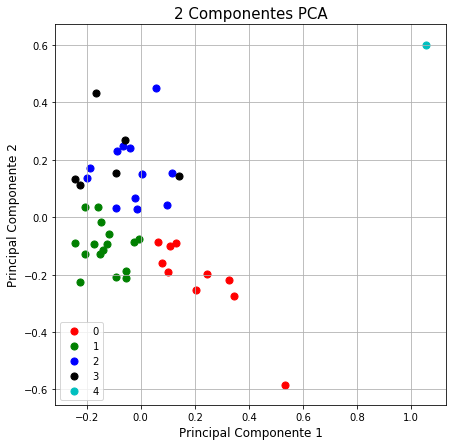

In [46]:
# Grafico

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Componente 1', fontsize = 12)
ax.set_ylabel('Principal Componente 2', fontsize = 12)
ax.set_title('2 Componentes PCA', fontsize = 15)


targets = sorted(finalDf['clust_k'].unique())
colors = ['r', 'g', 'b', 'k', 'c']

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['clust_k'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'Principal componente 1']
               , finalDf.loc[indicesToKeep, 'Principal componente 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

#### Jerárquico

In [54]:
autom_model.head()

,ind_04,ind_20,ind_22,ind_19
0,0.410,0.651,0.301,0.930
1,0.608,0.882,0.045,0.964
2,0.464,0.758,0.001,0.956
3,0.379,0.885,0.436,0.948
4,0.387,1.000,0.131,0.987


In [48]:
aut_col= Autom_CM.drop({'clust_k', 'cod_cia'},1)
aut_col=aut_col.columns
aut_col

Index(['ind_04', 'ind_20', 'ind_22', 'ind_19', 'denominacion_corta_x',
       'denominacion_corta_y'],
      dtype='object')

In [49]:
Autom_MJ= Autom_CM[aut_col]
Autom_MJ.head()

,ind_04,ind_20,ind_22,ind_19,denominacion_corta_x,denominacion_corta_y
0,0.410,0.651,0.301,0.930,SMG,SMG
1,0.608,0.882,0.045,0.964,SURA,SURA
2,0.464,0.758,0.001,0.956,BOSTON,BOSTON
3,0.379,0.885,0.436,0.948,ALLIANZ,ALLIANZ
4,0.387,1.000,0.131,0.987,QBE BUENOS AIRES,QBE BUENOS AIRES


In [50]:
Autom_MJ= Autom_MJ.set_index('denominacion_corta')
Autom_MJ.head()

KeyError: 'denominacion_corta'

In [51]:
# se unen los dos clusters para los cuales se tenga el menor incremento en el valor total de la suma de los cuadrados de 
# las diferencias, dentro de cada cluster, de cada individuo al centroide del cluster

Z = linkage(Autom_MJ, method="ward")
Z
plt.figure(figsize=(25,10))
plt.title("Dendrograma jerárquico para el Clustering")
plt.xlabel("Companía")
plt.ylabel("Distancia")
dendrogram(Z, labels=Autom_MJ.index, leaf_rotation=90., leaf_font_size=10.0, color_threshold=0.5*0.49)

#color_threshold: puedo establecer un umbral a partir del cual pintar los cluster

plt.show()

ValueError: could not convert string to float: 'LIBRA'

In [52]:
Z[-4:,]

NameError: name 'Z' is not defined

[2.26006929 1.81459378 1.63521128 1.31546503 1.12915458 0.86556403
 0.83435725 0.58443342 0.57594332 0.52538971]


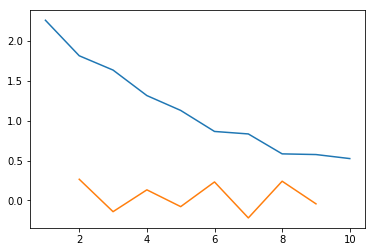

El número óptimo de cluster es 2


In [30]:
last = Z[-10:,2]
last_rev = last[::-1]
print(last_rev)
idx = np.arange(1, len(last)+1)
plt.plot(idx, last_rev)

acc = np.diff(last,2)
acc_rev = acc[::-1]
plt.plot(idx[:-2]+1, acc_rev)
plt.show()
k = acc_rev.argmax() +2
print("El número óptimo de cluster es %s"%str(k))